In [1]:
import tensorflow.compat.v2 as tf
import pandas as pd
import numpy as np
import functools
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from itertools import cycle
import os

import data_util_val

In [2]:
os.mkdir('metricas')
os.mkdir('metricas/lr2e-3')

In [3]:
#plt Config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

carpeta = 'metricas/lr2e-3/'
model_name = 'saved_model/15529/'

# Model Load and Inference

In [4]:
def build_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        #logging.info('Global batch size: %d', global_batch_size)
        #logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_finetune = get_preprocess_fn()
        num_classes = 5

        def map_fn(image, label):
            image = preprocess_fn_finetune(image)
            label = tf.one_hot(label, num_classes)
            return image, label

        #logging.info('Using Astro pretrain data')
        dataset = get_data_test()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = build_input_fn(batch_size)
    return strategy.experimental_distribute_datasets_from_function(input_fn)

def get_preprocess_fn():
    #Get function that accepts an image and returns a preprocessed image
    return functools.partial(
        data_util_val.preprocess_image,
        height = 330,
        width= 330)


def get_data_test():
    #logging.info('Loading Astro test data')
    data_dir = 'imagenes_clasificadas_nair/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('nairTest.csv')
    file_paths = df['name'].values
    labels = df['new_class'].values
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    ds_test = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_test = ds_test.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_test

def get_number_of_images(path_to_csv):
    df = pd.read_csv(path_to_csv)
    return df.shape[0]

In [5]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(128, strategy)
iterator = iter(ds)
saved_model = tf.saved_model.load(model_name)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Instructions for updating:
rename to distribute_datasets_from_function


In [6]:
normalized_logits_list, prediction_list = [], []
soft = keras.layers.Softmax()
for images, labels in iterator:
    logits = saved_model(images, trainable=False)['logits_sup']
    pred = tf.argmax(logits, -1)
    normalized_logits = soft(logits)
    pred = pred.numpy()
    normalized_logits = normalized_logits.numpy()
    normalized_logits_list.append(normalized_logits)
    prediction_list.append(pred)
    
predicted = np.concatenate(np.array(prediction_list, dtype=object), axis=0)
n_logits = np.concatenate(np.array(normalized_logits_list, dtype=object), axis=0)

In [7]:
dataset = pd.read_csv('nairTest.csv')
true_labels = dataset['new_class'].values

# Matriz de Confusion

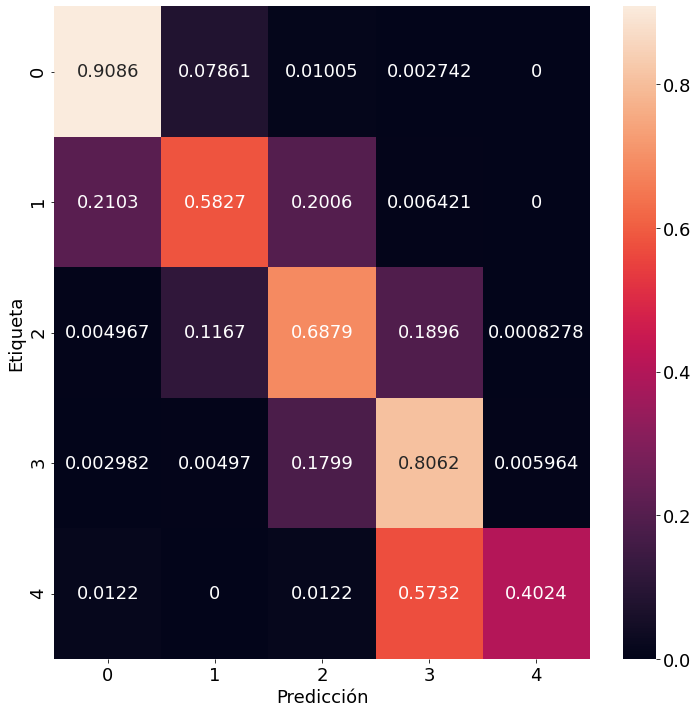

In [8]:
confusion = confusion_matrix(true_labels , predicted)
n_confusion = [confusion[i,:]/confusion.sum(axis=1)[i] for i in range(5)]
plt.figure(figsize=(12,12))
sns.heatmap(n_confusion, annot=True, fmt='.4g')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta')
plt.savefig(carpeta + "confusion.pdf", format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# ROC - AUC

In [9]:
one_hot = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

FPR, TPR, ACC = [], [], []
for i in range(5):
    fpr, tpr, _ = roc_curve(one_hot[:,i], n_logits[:,i])
    acc = auc(fpr, tpr)
    FPR.append(fpr)
    TPR.append(tpr)
    ACC.append(acc)

#compute macro avg ROC
all_FPR = np.unique(np.concatenate([FPR[i] for i in range(5)]))
mean_TPR = np.zeros_like(all_FPR)
for i in range(5):
    mean_TPR += np.interp(all_FPR, FPR[i], TPR[i])
mean_TPR /= 5
macro_AUC = auc(all_FPR, mean_TPR)

# Compute micro-average ROC
micro_FPR, micro_TPR, _ = roc_curve(one_hot.ravel(), n_logits.ravel())
micro_ACC = auc(micro_FPR, micro_TPR)

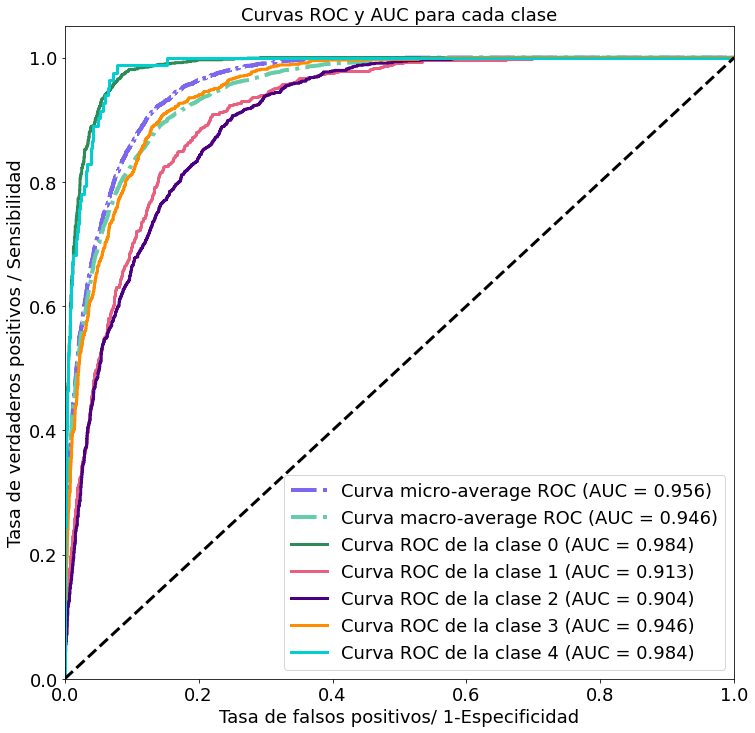

In [10]:
plt.figure(figsize=(12,12))
ax =plt.plot(micro_FPR, micro_TPR,
         label='Curva micro-average ROC (AUC = {0:0.3f})'
               ''.format(micro_ACC),
         color='mediumslateblue', linestyle='-.', linewidth=4)

plt.plot(all_FPR, mean_TPR,
         label='Curva macro-average ROC (AUC = {0:0.3f})'
               ''.format(macro_AUC),
         color='mediumaquamarine', linestyle='-.', linewidth=4)

colors = cycle(['seagreen','#e85f7f','indigo','darkorange','darkturquoise'])
for i, color in zip(range(5), colors):
    plt.plot(FPR[i], TPR[i], color=color, lw=3,
             label='Curva ROC de la clase {0} (AUC = {1:0.3f})'
             ''.format(i, ACC[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Curvas ROC y AUC para cada clase')
plt.xlabel('Tasa de falsos positivos/ 1-Especificidad')#, fontsize=16)
plt.ylabel('Tasa de verdaderos positivos / Sensibilidad')
plt.legend(loc="lower right")
plt.savefig(carpeta+"roc.pdf", format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Curvas Precision - Recall

In [11]:
PRECISION, RECALL, avg_PRECISION = [], [], []
for i in range(5):
    precision, recall, _ = precision_recall_curve(one_hot[:, i],n_logits[:, i])
    average_precision = average_precision_score(one_hot[:, i],n_logits[:, i])
    PRECISION.append(precision)
    RECALL.append(recall)
    avg_PRECISION.append(average_precision)

#micro precision recall
micro_precision, micro_recall,_ = precision_recall_curve(one_hot.ravel(), n_logits.ravel())
micro_avg_precision = average_precision_score(one_hot, n_logits, average="micro")

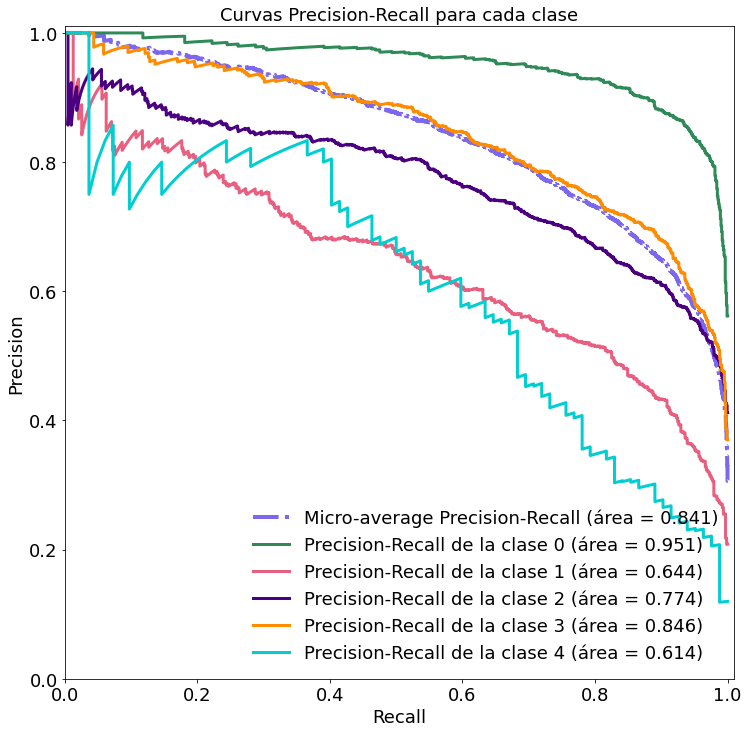

In [12]:
plt.figure(figsize=(12,12))
ax =plt.plot(micro_recall, micro_precision,
         label='Micro-average Precision-Recall (área = {0:0.3f})'
               ''.format(micro_avg_precision),
         color='mediumslateblue', linestyle='-.', linewidth=4)

colors = cycle(['seagreen','#e85f7f','indigo','darkorange','darkturquoise'])
for i, color in zip(range(5), colors):
    plt.plot(RECALL[i], PRECISION[i], color=color, lw=3,
             label='Precision-Recall de la clase {0} (área = {1:0.3f})'
             ''.format(i, avg_PRECISION[i]))

plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title('Curvas Precision-Recall para cada clase')
plt.xlabel('Recall')#, fontsize=16)
plt.ylabel('Precision')
plt.legend(loc="lower right", framealpha=0.0)
plt.savefig(carpeta + "precision-recall.pdf", format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Otras metricas

In [13]:
print(classification_report(true_labels, predicted, target_names=['Clase 0', 'Clase 1', 'Clase 2',
                                                                 'Clase 3', 'Clase 4'], digits=4))

              precision    recall  f1-score   support

     Clase 0     0.8758    0.9086    0.8919      1094
     Clase 1     0.6101    0.5827    0.5961       623
     Clase 2     0.7232    0.6879    0.7051      1208
     Clase 3     0.7413    0.8062    0.7724      1006
     Clase 4     0.8250    0.4024    0.5410        82

    accuracy                         0.7555      4013
   macro avg     0.7551    0.6776    0.7013      4013
weighted avg     0.7539    0.7555    0.7526      4013



In [14]:
report = classification_report(true_labels, predicted, target_names=['Clase 0', 'Clase 1', 'Clase 2',
                                                                 'Clase 3', 'Clase 4'], digits=4, output_dict=True)

In [15]:
df = pd.DataFrame(report).transpose()
df.to_csv(carpeta+'clasification-report.csv')